In [ ]:
#!/usr/bin/env python
"""
Script para calcular cliamtologia de ETP

__author__: "Duvan Nieves, Carlos David Hoyos"
__version__: "0.0.1"
__email__:"dnieves@unal.edu.co"
__status__:"Developer"
__references__:
    - [Data page]    : https://www.ncei.noaa.gov/products/weather-balloon/integrated-global-radiosonde-archive
    - [Data format]  : https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/doc/igra2-data-format.txt
    - [Original code]: https://carlosdhoyos.github.io/intro_to_climatology/
    - [Metadata]     : https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/doc/igra2-station-list.txt
    - [Country List] : https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/doc/igra2-country-list.txt
    - [MJO- RMM]     : https://www.bom.gov.au/climate/mjo/
    - [RMM]          : https://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt
__changues__:
    - [2025-09-03][Carlos]: Primera version del Codigo.
    - [2025-09-03][Duvan]: Se modifica la lectura de las esatciones.
    - [2025-09-03][Duvan]: Se modifica la función de parseo, de acuerdo a la pagina oficial.
"""

# MODULOS

In [248]:
!pip install cartopy

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [250]:
from re import compile
from io import BytesIO
from gc import collect
from requests import get
from subprocess import run
from zipfile import ZipFile
from seaborn import kdeplot
from os import path, makedirs
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from cartopy import crs, feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from numpy import nan,gradient,trapezoid,maximum,exp,full_like,unique,isnan,full,interp,log,arange
from pandas import read_fwf,to_numeric,Timestamp,DataFrame,notna,concat,read_pickle,Series,to_datetime

# FUNCIONES

## [IGRA](https://carlosdhoyos.github.io/intro_to_climatology/igra.html)

In [251]:
QC_LETTER_RE = compile(r'[A-Za-z]')

def _to_num(token: str, scale=1.0, missing=[-9999,-8888], allow_signed=True):
    if token is None:
        return nan
    t = QC_LETTER_RE.sub('', token.strip())
    if t == '':
        return nan
    try:
        val = int(t) if allow_signed else int(t.replace('-', ''))
    except ValueError:
        return nan
    if val in missing:
        return nan
    return val / scale

def parse_header(header_line: str):
    stn_id    = header_line[1:12].strip()
    year      = int(header_line[13:17])
    month     = int(header_line[18:20])
    day       = int(header_line[21:23])
    hour      = int(header_line[24:26])
    #real_time = str(header_line[27:29] + header_line[29:31])
    ts = Timestamp(datetime(year, month, day,00 if hour in [88,99] else hour))
    try:
        approx_levels = int(header_line[31:36].strip())
    except Exception:
        approx_levels = None
    return stn_id, ts, approx_levels

def parse_level_line(ln: str) -> dict:
   return {
       "level_type1": int(ln[0]),
       "level_type2": int(ln[1]),
       "pressure_hPa": _to_num(ln[9:15], scale=100.0, missing=[-9999,-99.99,-8888,-88.88]),
       "height_m": _to_num(ln[16:21], scale=1.0, missing=[-9999,-8888]),
       "temp_C": _to_num(ln[22:27], scale=10.0, missing=[-9999,-999.9,-8888,-888.8]),
       "rh_pct": _to_num(ln[28:33], scale=10.0, missing=[-9999,-999.9,-8888,-888.8]),
       "dewpoint_C": _to_num(ln[34:39], scale=10.0, missing=[-9999,-999.9,-8888,-888.8]),
       "wind_dir_deg": _to_num(ln[40:45], scale=1.0, missing=[-9999,-8888]),
       "wind_speed_mps": _to_num(ln[46:51], scale=10.0, missing=[-9999,-999.9,-8888,-888.8]),
   }
def split_into_soundings(lines: list[str]):
    soundings = []
    cur_header, cur_levels = None, []
    def flush():
        nonlocal cur_header, cur_levels
        if cur_header is not None and cur_levels:
            soundings.append((cur_header, cur_levels))
        cur_header, cur_levels = None, []
    for ln in lines:
        if not ln.strip():
            continue
        if ln.startswith('#'):
            flush()
            cur_header = ln
        else:
            cur_levels.append(ln)
    flush()
    return soundings

def build_catalog_and_metadata(lines: list[str], drop_empty: bool = True):
    """
    Returns:
      catalog: dict[catalog_key -> DataFrame]
      meta:    DataFrame with per-sounding stats (includes 'catalog_key' and 'status')
    If drop_empty=True, both outputs exclude soundings classified as 'empty'.
    """
    soundings = split_into_soundings(lines)
    catalog = {}
    meta_rows = []

    # handle duplicate timestamps by suffixing keys
    duplicates_count: dict[Timestamp, int] = {}

    for header, level_lines in soundings:
        stn_id, ts, approx_count = parse_header(header)
        rows = [parse_level_line(ln) for ln in level_lines]
        df = DataFrame(rows)
        df.insert(0, "station", stn_id)
        df.insert(1, "time", ts)

        # classify BEFORE dropping anything
        n_valid_pres = int(df["pressure_hPa"].notna().sum())
        n_valid_temp = int(df["temp_C"].notna().sum())
        n_valid_wind = int(df["wind_speed_mps"].notna().sum())

        if n_valid_pres == 0 and n_valid_temp == 0 and n_valid_wind == 0:
            status = "empty"
        elif n_valid_pres == 0 and n_valid_temp == 0 and n_valid_wind > 0:
            status = "winds_only"
        elif n_valid_temp == 0 and n_valid_pres > 0:
            status = "pressure_only"
        else:
            status = "full"

        # now drop rows that are completely useless across all key fields
        df = df.dropna(
            how="all",
            subset=["pressure_hPa","height_m","temp_C","dewpoint_C","wind_dir_deg","wind_speed_mps"]
        ).reset_index(drop=True)

        # sort by pressure if present; else by height if present
        if df["pressure_hPa"].notna().any():
            df = df.sort_values("pressure_hPa", ascending=False).reset_index(drop=True)
        elif df["height_m"].notna().any():
            df = df.sort_values("height_m", ascending=True).reset_index(drop=True)

        # unique catalog key (timestamp + optional suffix)
        if ts in duplicates_count:
            duplicates_count[ts] += 1
            key = f"{ts.isoformat()}.{duplicates_count[ts]}"
        else:
            duplicates_count[ts] = 1
            key = ts.isoformat()

        # store even if empty for now; we'll filter at the end if requested
        catalog[key] = df

        # compute simple stats from the (lightly) cleaned df
        n_levels = len(df)
        p_max = float(df["pressure_hPa"].max()) if df["pressure_hPa"].notna().any() else nan
        p_min = float(df["pressure_hPa"].min()) if df["pressure_hPa"].notna().any() else nan
        z_top = float(df["height_m"].max()) if df["height_m"].notna().any() else nan

        meta_rows.append({
            "catalog_key": key,
            "station": stn_id,
            "time": ts,
            "status": status,
            "approx_levels_header": approx_count,
            "n_levels": n_levels,
            "n_valid_pressure": n_valid_pres,
            "n_valid_temp": n_valid_temp,
            "n_valid_wind": n_valid_wind,
            "p_max_hPa_surface": p_max,
            "p_min_hPa_top": p_min,
            "z_top_m": z_top,
        })

    meta = DataFrame(meta_rows).sort_values("time").reset_index(drop=True)

    if drop_empty:
        # keep only non-empty in meta
        meta = meta[meta["status"] != "empty"].reset_index(drop=True)
        # align catalog to filtered meta
        keep_keys = set(meta["catalog_key"])
        catalog = {k: v for k, v in catalog.items() if k in keep_keys}

    return catalog, meta

## [RMM](https://carlosdhoyos.github.io/intro_to_climatology/RMM.html)

In [252]:
def load_rmm_from_file(path: str) -> DataFrame:
    """
    Parse a local BoM RMM text file.

    Returns DataFrame with ['rmm1','rmm2','phase','amplitude'] indexed by datetime.
    Skips headers and drops missing (1.E36 or 999).
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            c0 = line[0]
            # Keep only lines beginning with a year (numeric or leading minus)
            if not (c0.isdigit() or (c0 == "-" and len(line) > 1 and line[1].isdigit())):
                continue
            parts = line.split()
            if len(parts) < 7:
                continue
            try:
                y = int(parts[0]); m = int(parts[1]); d = int(parts[2])
                r1 = float(parts[3]); r2 = float(parts[4]); ph = int(parts[5]); amp = float(parts[6])
            except ValueError:
                continue
            # Drop missing per header: 1.E36 or 999
            if any(abs(v) >= 1e35 for v in (r1, r2, amp)) or any(v == 999 for v in (r1, r2, amp)):
                continue
            rows.append({
                "date": datetime(y, m, d),
                "rmm1": r1, "rmm2": r2, "phase": ph, "amplitude": amp
            })
    if not rows:
        raise ValueError("No RMM rows parsed from file.")
    return DataFrame(rows).set_index("date").sort_index()

## PROPIAS

In [253]:
def calc_theta(T, P, P0=1000.0):
    """
    Calcula la temperatura potencial (θ).

    Fórmula
    -------
    θ = (T + 273.15) * (P0 / P) ** kappa

    Parámetros
    ----------
    T : float o array-like
        Temperatura en grados Celsius.
    P : float o array-like
        Presión en hPa.
    P0 : float, opcional
        Presión de referencia en hPa (por defecto 1000.0 hPa).

    Constantes utilizadas
    ---------------------
    Rd : float
        Constante de gas para aire seco (287.05 J kg^-1 K^-1).
    cp : float
        Calor específico a presión constante (1004.0 J kg^-1 K^-1).
    kappa : float
        Cociente Rd/cp = 0.2859064.

    Retorna
    -------
    theta : float o array-like
        Temperatura potencial en Kelvin.
    """
    return (T + 273.15) * (P0 / P) ** 0.2859064

def calc_theta_e(T, P, Td, P0=1000.0):
    """
    Calcula la temperatura potencial equivalente (θe).

    Fórmula
    -------
    θe = θ * exp( (L * r) / (cp * T_K) )

    donde:
      - θ  = (T + 273.15) * (P0 / P) ** κ
      - r  = 0.622 * e / (P - e)
      - e  = 6.112 * exp(17.67 * Td / (Td + 243.5))  (hPa)

    Parámetros
    ----------
    T : float o array-like
        Temperatura en °C.
    P : float o array-like
        Presión en hPa.
    Td : float o array-like
        Temperatura de rocío en °C.
    P0 : float, opcional
        Presión de referencia en hPa (por defecto 1000.0 hPa).

    Constantes utilizadas
    ---------------------
    Rd : float
        Constante de gas del aire seco = 287 J·kg⁻¹·K⁻¹.
    cp : float
        Calor específico del aire seco a presión constante = 1004 J·kg⁻¹·K⁻¹.
    κ (kappa) : float
        Rd / cp ≈ 0.2859064 (adimensional).
    L : float
        Calor latente de vaporización ≈ 2.5 × 10⁶ J·kg⁻¹.

    Retorna
    -------
    theta_e : float o array-like
        Temperatura potencial equivalente en Kelvin.

    Notas
    -----
    - Implementación completa usando L/cp y razón de mezcla explícita.
    - La temperatura debe convertirse a Kelvin para el término exponencial.
    """
    T_K = T + 273.15
    e = maximum(0, 6.112 * exp(17.67 * Td / (Td + 243.5)))
    r = 0.622 * e / maximum(P - e, 0.01)  # Evita división por cero
    return T_K * (P0 / P) ** 0.2859064 * exp(2490 * r / T_K)  # L/cp ≈ 2490

def calc_lapse_rate(T, z):
    """
    Calcula la tasa de gradiente de temperatura (lapse rate).

    Fórmula
    -------
    Γ = -dT/dz * 1000

    Parámetros
    ----------
    T : array-like
        Temperatura en °C (o K, se conserva la unidad en el resultado).
    z : array-like
        Altura en metros.

    Retorna
    -------
    lapse_rate : array-like
        Gradiente de temperatura en K/km (positivo cuando T decrece con altura).
        Devuelve NaN si hay valores inválidos o z no varía.

    Notas
    -----
    El signo negativo hace que valores positivos indiquen enfriamiento con altura,
    que es la convención meteorológica estándar.
    """
    return full(T.shape, nan) if len(unique(z)) <= 1 or isnan(T).any() or isnan(z).any() else -gradient(T, z) * 1000

def calc_cape(T, P, Td, z):
    """
    Calcula la Energía Potencial Convectiva Disponible (CAPE) simplificada.

    Fórmula aproximada
    ------------------
    CAPE ≈ g * ∫ max(0, (θe_parcela - θe_ambiente) / θe_ambiente) * dz

    Parámetros
    ----------
    T : array-like
        Temperatura en °C.
    P : array-like
        Presión en hPa.
    Td : array-like
        Temperatura de rocío en °C.
    z : array-like
        Altura en metros.

    Retorna
    -------
    cape : float
        CAPE aproximado en J/kg.
        Devuelve NaN si hay valores inválidos o z no varía.

    Notas
    -----
    Esta es una aproximación simplificada. El cálculo riguroso requiere
    integrar la diferencia de temperatura virtual entre una parcela
    adiabática y el ambiente.
    """
    if len(z) <= 1 or isnan(T).any() or isnan(P).any() or isnan(Td).any() or isnan(z).any():
        return nan
    theta_e = calc_theta_e(T, P, Td)
    theta_e_mean = theta_e.mean()
    return 9.80665 * trapezoid(maximum(0, (theta_e - theta_e_mean) / theta_e_mean), z)


def interp_levels(group):
    """
    Interpola temperaturas a niveles de presión 1000 y 850 hPa desde datos agrupados.

    Args:
        group: DataFrame con columnas 'pressure_hPa' y 'temp_K'

    Returns:
        Series: Temperaturas interpoladas ['T_1000', 'T_850'] o nan si imposible

    Requiere variables globales p_bottom (1000) y p_top (850).
    """
    p, T = group['pressure_hPa'].values, group['temp_K'].values
    if len(p) < 2 or p.min() > p_bottom or p.max() < p_top:
        return Series([nan, nan], index=['T_1000', 'T_850'])
    p_sorted, T_sorted = zip(*sorted(zip(p, T)))
    p_dict = dict(zip(p_sorted, T_sorted))
    T_1000 = p_dict.get(p_bottom) or (interp(p_bottom, p_sorted[::-1], T_sorted[::-1]) if p_bottom >= min(p_sorted) and p_bottom <= max(p_sorted) else nan)
    T_850 = p_dict.get(p_top) or (interp(p_top, p_sorted[::-1], T_sorted[::-1]) if p_top >= min(p_sorted) and p_top <= max(p_sorted) else nan)
    return Series([T_1000, T_850], index=['T_1000', 'T_850'])


# PATHS-URL

In [ ]:
principal_path = '/workspaces/Clima-2025S2/'
data_path      = principal_path + 'Datos/HW1/'
path_fig       = principal_path + 'Figs/HW1'
igrav2_meta    = 'https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/doc/igra2-station-list.txt'
igrav2_file    = "https://www.ncei.noaa.gov/pub/data/igra/data/data-por/{station_id}-data.txt.zip"
rmm_data       = "https://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt"

# METADATOS IGRAV2

## DESCARGA METADATOS

In [255]:
if not path.exists(data_path + 'igra2-station-list.txt'):
   makedirs(data_path, exist_ok=True)
   run(["wget", "-P", data_path, igrav2_meta])

## LECTURA DE METADATOS

In [256]:
stations = read_fwf(
    data_path + 'igra2-station-list.txt',
    header=None,
    names=['id','lat','lon','elev_m','name','Fechai','Fechaf','records'])

## SELECCIÓN MJO

In [257]:
mjo_stations   = stations[(stations["lon"].between(65, 160)) & (stations["lat"].between(-15, 15))].reset_index(drop=True)
mjo_station55 =  mjo_stations[mjo_stations["lat"].between(-5, 5)]

In [258]:
no_full_data = ['BXM00096323','IDM00096015','IDM00096207','IDM00096249',
                'IDM00096273','IDM00096529','IDM00096535','IDM00096565',
                'IDM00096607','IDM00096595','IDM00096607','IDM00096655',
                'IDM00097048','IDM00097096','IDM00097146','IDM00097460',
                'IDM00097530','IDM00097748','IDM00097760','IDM00096073',
                'IDM00096145','IDM00096179','PPM00094085',

                'BMM00048108','BMM00048109','BMM00048110','BMM00048112',
                'CBM00048992','CEM00043413','CEM00043418','CEM00043421',
                'CEM00043424','CEM00043475','CEM00043497','IDM00096737',
                'IDM00096755','IDM00096773','IDM00096791','IDM00096797',
                'IDM00096801','IDM00096845','IDM00096853','IDM00096947',
                'IDM00097192','IDM00097260','IDM00097810','IDM00097876',
                'INM00043237','INM00043284','INM00043344','INXUAE05457',
                'KTM00096995','MYM00048602','PPM00094047','RPM00098630',
                'RPM00098653','RPM00098754','THM00048426','THM00048456',
                'THM00048456','THM00048532','TTM00097385','TTM00097388',
                'TTM00097395','VMM00048870','VMM00048877','VMM00048913',
                'TTM00097390'
                ]

In [259]:
print(f"Radiosondeos Buenos: {len(mjo_stations[~mjo_stations['id'].isin(no_full_data)])}")

Radiosondeos Buenos: 129


# DESCARGA DE RADIO SONDEOS SELCCIONADOS

In [260]:
for index, station in mjo_stations[~mjo_stations['id'].isin(no_full_data)].iterrows():
  station_file = data_path + station["id"] + '_full.pickle'
  if not path.exists(station_file):
    url_station = igrav2_file.format(station_id=station["id"])
    print("Downloading:", station["id"], station["name"], 'from:', url_station)
    r = get(url_station)
    z = ZipFile(BytesIO(r.content))
    fname = z.namelist()[0]
    lines = z.read(fname).decode("utf-8").splitlines()
    catalog, meta = build_catalog_and_metadata(lines, drop_empty=True)
    if "full" not in meta["status"].value_counts():
        print(f"WARNING: No 'full' records found for {station['id']} {station['name']}")
        continue
    percent = round(100*(meta["status"].value_counts()["full"].item()/len(catalog)),3)
    meta_full = meta[meta["status"] == "full"].reset_index(drop=True)
    catalog_full = {k: catalog[k] for k in meta_full["catalog_key"]}
    catalog_combined = concat(catalog_full.values(), ignore_index=True)
    catalog_combined.attrs = {'station_id': station["id"], 'station_name': station["name"], 'url_source': url_station, 'download_date': datetime.now().isoformat(), 'completion_percent': percent, 'total_records': len(catalog), 'full_records': meta["status"].value_counts()["full"].item()}
    catalog_combined.to_pickle(station_file)
    print("Download Finish,",'Range:',f"{catalog_combined['time'].min().strftime('%Y')}-{catalog_combined['time'].max().strftime('%Y')}")
  else:
    print("Already downloaded:", station["id"], station["name"])
collect()

Already downloaded: ASM00094120 DARWIN AIRPORT
Already downloaded: ASM00094155 EAST ARNHEM
Already downloaded: ASM00094170 WEIPA AERO
Already downloaded: ASM00094175 USAF-DS3-659
Already downloaded: BPM00091517 HONIARA
Already downloaded: BXM00096315 BRUNEI AIRPORT
Already downloaded: CEM00043466 COLOMBO
Already downloaded: CHM00056029 YUSHU (56029-0)
Already downloaded: CHM00056080 HEZUO
Already downloaded: CKM00096996 COCOS ISLAND AERO
Already downloaded: FMM00091317 WOLEAI ATOLL
Already downloaded: FMM00091334 TRUK/CAROLINE IS.
Already downloaded: FMM00091348 PONAPE/CAROLINE IS.
Already downloaded: FMM00091413 YAP/CAROLINE IS.
Already downloaded: FMM00091434 KAPINGAMARANGI ATOL
Already downloaded: GQM00091212 WEATHER FORECAST OFFICE; GUAM;
Already downloaded: IDM00096009 LHOKSEUMAWE/MALIKUSSALEH
Already downloaded: IDM00096011 BANDA ACEH/BLANG BINTANG
Already downloaded: IDM00096035 KUALANAMU MEDAN
Already downloaded: IDM00096075 GUNUNG SITOLI/BINAKA
Already downloaded: IDM00096091 

32

# DATOS RMM

## DESCARGA

In [261]:
if not path.exists(data_path + 'rmm.74toRealtime.txt'):
   makedirs(data_path, exist_ok=True)
   run(["wget", "--user-agent=Mozilla/5.0", "-P", data_path, rmm_data])
# Si falla decargue manual (Tiene bloqueo de Webscraping)

## LECTURA

In [262]:
rmm = load_rmm_from_file(data_path + 'rmm.74toRealtime.txt')

# SELECCION DE RADIOSONDEOS

## DISPONIBILIDAD REAL DE DATOS FULL

In [263]:
stations_info = DataFrame([(station["id"], station["name"],
                              (data := read_pickle(data_path + station["id"] + '_full.pickle'))['time'].min().year,
                              data['time'].max().year)
                             for _, station in mjo_stations[~mjo_stations['id'].isin(no_full_data)].iterrows()
                             if path.exists(data_path + station["id"] + '_full.pickle')],
                            columns=['id', 'name', 'start_year', 'end_year'])
stations_info['years'] = stations_info['end_year'] - stations_info['start_year']
stations_info.sort_values('years', ascending=False, inplace=True)
#stations_info.query('years >= 50', inplace=True)
stations_info

,id,name,start_year,end_year,years
0,ASM00094120,DARWIN AIRPORT,1943,2025,82
69,INM00043295,BENGALURU,1945,2025,80
15,GQM00091212,WEATHER FORECAST OFFICE; GUAM;,1947,2025,78
76,INM00043371,THIRUVANANTHAPURAM (43371-0),1947,2025,78
13,FMM00091413,YAP/CAROLINE IS.,1949,2025,76
...,...,...,...,...,...
74,INM00043368,USAF-DS3-279,1979,1979,0
96,PPM00094076,USAF-DS3-656,1994,1994,0
91,MYM00096491,SANDAKAN,1999,1999,0
117,THM00048551,SURAT THANI,2010,2010,0


In [264]:
stations_info[stations_info['id'].isin(mjo_station55['id'])].head(10)

,id,name,start_year,end_year,years
110,SNM00048698,SINGAPORE/CHANGI AIRPORT,1955,2025,70
7,CHM00056029,YUSHU (56029-0),1959,2025,66
8,CHM00056080,HEZUO,1960,2025,65
109,RSM00031770,SOVETSKAYA GAVAN,1964,2025,61
79,MVM00043599,GAN,1961,2021,60
86,MYM00048657,KUANTAN,1971,2025,54
60,IDM00097560,BIAK/FRANS KAISIEPO,1973,2025,52
46,IDM00097014,MENADO/ SAM RATULANGI,1973,2025,52
18,IDM00096035,KUALANAMU MEDAN,1975,2025,50
87,MYM00096413,KUCHING,1976,2025,49


## MAPA DE RADIOSONDEOS

In [265]:
selected_stations = ['PSM00091408','SNM00048698','MYM00048657','IDM00097560','IDM00097014']
metadata_station = mjo_stations[mjo_stations['id'].isin(selected_stations)]
metadata_station = metadata_station.assign(color=["#134686","#EF7722", "#B45253","#3E3F29", "#799EFF"])

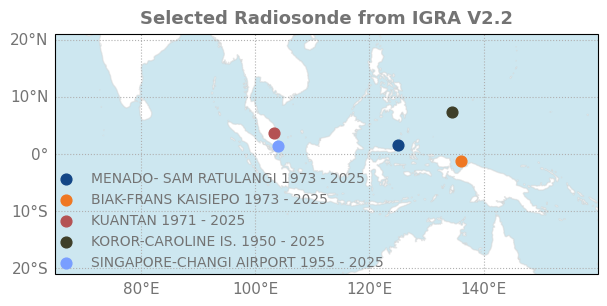

In [266]:
fig = plt.figure(figsize=(7,8), facecolor='w', edgecolor='w')
ax = fig.add_subplot(111,projection= crs.PlateCarree())
#ax.set_aspect('auto')
ax.coastlines(color='lightgray',alpha=.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue',alpha=.6)
gl = ax.gridlines(crs=crs.PlateCarree(),draw_labels=True,linestyle=':')
gl.top_labels,gl.right_labels = False,False
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': (0.45, 0.45, 0.45)}
gl.ylabel_style = {'size': 11, 'color': (0.45, 0.45, 0.45)}
gl.yformatter = LATITUDE_FORMATTER
ax.set_xlim(65,160)
ax.set_ylim(-21,21)
for _,radiosonde in metadata_station.iterrows():
  label = f"{radiosonde['name'].replace('/','-')} {radiosonde['Fechai']} - {radiosonde['Fechaf']}"
  ax.scatter(radiosonde['lon'],radiosonde['lat'],marker='o',s=60,label = label,color=radiosonde['color'],zorder=5)
ax.set_title(f'Selected Radiosonde from IGRA V2.2', color=(0.45, 0.45, 0.45), pad=8, fontsize=13,fontweight='bold')
leg = ax.legend(bbox_to_anchor=(0.3, 0.48),frameon=False,
                handlelength=2,loc='upper center', ncol=1)
for text in leg.get_texts():
    text.set_color((0.45, 0.45, 0.45))
    text.set_fontsize(10)
fig.savefig(path_fig + f'Map_stations.png', dpi=300, bbox_inches="tight",transparent=False)

## LECTURA DE RADIOSONDEOS

In [267]:
#all_station_mjo = concat([read_pickle(data_path + row['id'] + '_full.pickle') for _, row in stations_info.iterrows()]).reset_index(drop=True)
selected_stations = ['ASM00094120','CHM00056029','CHM00056080','PSM00091408','RSM00031770','SNM00048698']
selected_stations = ['PSM00091408','SNM00048698','MVM00043599','MYM00048657','IDM00097560','IDM00097014']
selected_stations = ['PSM00091408','SNM00048698','MYM00048657','IDM00097560','IDM00097014']
#'PSM00091408','INM00043295','GQM00091212','INM00043371','FMM00091413','IDM00096035'
selected_stations = ['PSM00091408','SNM00048698']
#selected_stations = ['MYM00048657','IDM00097560']
#selected_stations = ['IDM00097014']
#


In [268]:
print(stations_info[stations_info['id'].isin(selected_stations)].to_csv(sep='\t'))

	id	name	start_year	end_year	years
98	PSM00091408	KOROR/CAROLINE IS.	1950	2025	75
110	SNM00048698	SINGAPORE/CHANGI AIRPORT	1955	2025	70



# REVISION DE CALIDAD

## LIMPIEZA DE DATOS

In [269]:
all_station_mjo_quality = concat([
    (lambda df: df.assign(
        temp_K=df['temp_C'] + 273.15,
        theta=calc_theta(df['temp_C'], df['pressure_hPa']),
        theta_e=calc_theta_e(df['temp_C'], df['pressure_hPa'],df['dewpoint_C']),
        date=to_datetime(df['time'].dt.date)
    ))(read_pickle(data_path + row['id'] + '_full.pickle'))
    for _, row in stations_info[stations_info['id'].isin(selected_stations)].iterrows()
])
collect()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


7026

In [270]:
all_station_mjo_quality['station'].unique()

array(['PSM00091408', 'SNM00048698'], dtype=object)

In [271]:
ref_start, ref_end = 1981, 2010
all_station_mjo_quality['year'] = all_station_mjo_quality['date'].dt.year
all_station_mjo_quality['doy'] = all_station_mjo_quality['date'].dt.dayofyear
ref_data = all_station_mjo_quality[(all_station_mjo_quality['year'] >= ref_start) & (all_station_mjo_quality['year'] <= ref_end)]
clim_base = ref_data.groupby(['station','pressure_hPa','doy'])['theta'].agg(['mean','std'])
clim_rolled = clim_base.reset_index().copy()
clim_rolled = clim_base.groupby(['station','pressure_hPa']).rolling(window=15, center=True, min_periods=5).mean().droplevel([0,1]).reset_index()
clim_rolled.columns = ['station','pressure_hPa','doy','theta_clim','theta_std_clim']
all_station_mjo_quality = all_station_mjo_quality.merge(clim_rolled, on=['station','pressure_hPa','doy'], how='left')
all_station_mjo_quality['doy_theta_anom'] = all_station_mjo_quality['theta'] - all_station_mjo_quality['theta_clim']
all_station_mjo_quality['doy_theta_anom_std'] = all_station_mjo_quality['doy_theta_anom'] / all_station_mjo_quality['theta_std_clim']
all_station_mjo_quality_final = all_station_mjo_quality.set_index('date').join(rmm, how='left').dropna(subset = ['doy_theta_anom','rmm1',	'rmm2',	'phase',	'amplitude'])

In [273]:
for column in all_station_mjo_quality.select_dtypes('float').columns:
  data = all_station_mjo_quality[column]
  print(column,data.min(),data.max())
  #data.plot(kind='box')
  #plt.show()

pressure_hPa 0.2 1015.0
height_m 0.0 58474.0
temp_C -95.3 34.4
rh_pct 0.0 100.0
dewpoint_C 0.0 70.0
wind_dir_deg 0.0 360.0
wind_speed_mps 0.0 149.2
temp_K 177.84999999999997 307.54999999999995
theta 286.95 2178.69206749117
theta_e 302.4551457366562 inf
theta_clim 295.88140937722886 1377.5983383130965
theta_std_clim 0.07977261633842905 38.2508087609127
doy_theta_anom -145.1409084241535 156.8973307085248
doy_theta_anom_std -20.80072447990479 22.15601247717747


# ESTIMACIONES

## CONSTANTES - VARIABLES



In [274]:
Rd    = 287.05  # J kg^-1 K^-1
g     = 9.80665  # m s^-2
kappa = 0.2859064
p0    = 1000.0  # hPa
p_bottom, p_top = 1000.0, 850.0
ref_start, ref_end = 1981, 2010

## PERFILES

In [275]:
standard_levels = [1000, 925, 850, 700, 500, 400, 300, 250, 200]
low_levels      = arange(1000,850,-10)

In [276]:
all_station_mjo_quality_final['mjo_group'] = all_station_mjo_quality_final['phase'].map({1:'1-8', 8:'1-8', 2:'2-3', 3:'2-3', 4:'4-5', 5:'4-5', 6:'6-7', 7:'6-7'})
composite_data = all_station_mjo_quality_final.query('amplitude >= 1.0').groupby(['station','mjo_group', 'pressure_hPa'])[['doy_theta_anom','height_m']].mean().reset_index()
composite_data_slv = composite_data[composite_data['pressure_hPa'].isin(standard_levels)]
composite_data_llv = composite_data[composite_data['pressure_hPa'].isin(low_levels)]

In [277]:
all_station_mjo_quality_final['station'].unique()

array(['PSM00091408', 'SNM00048698'], dtype=object)

PSM00091408
SNM00048698
PSM00091408
SNM00048698


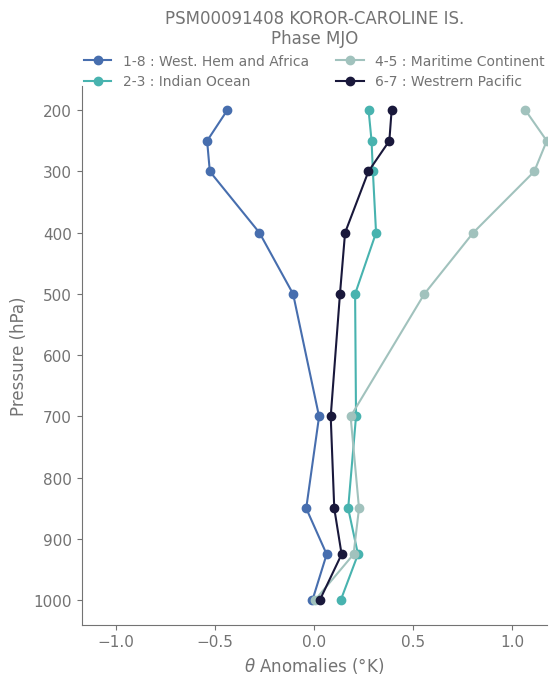

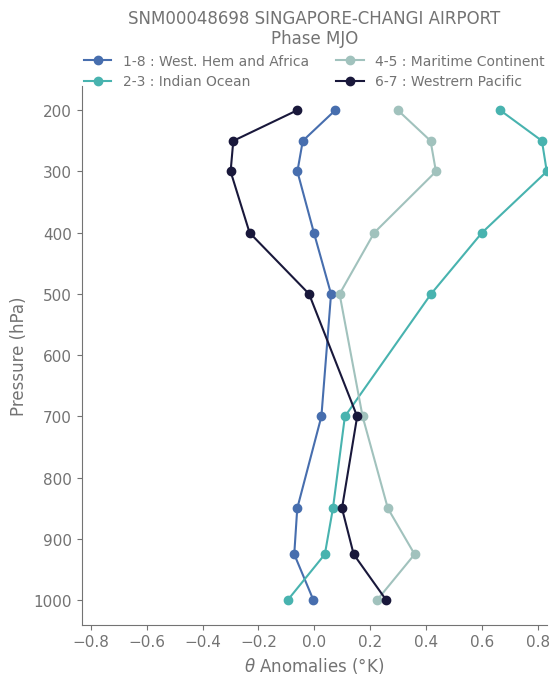

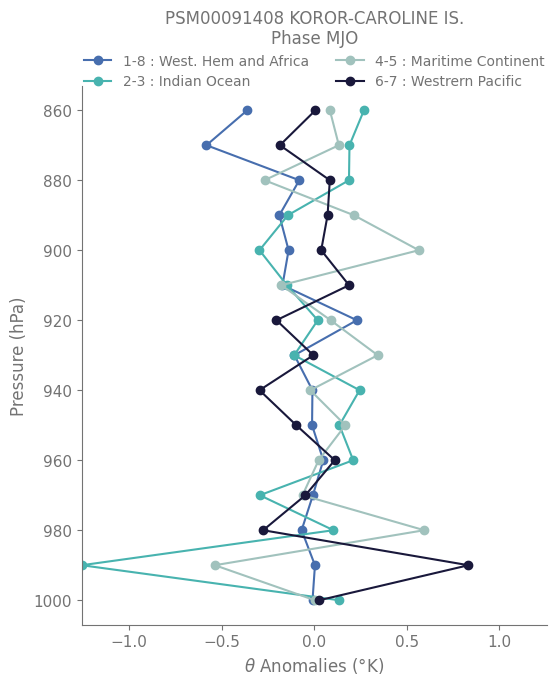

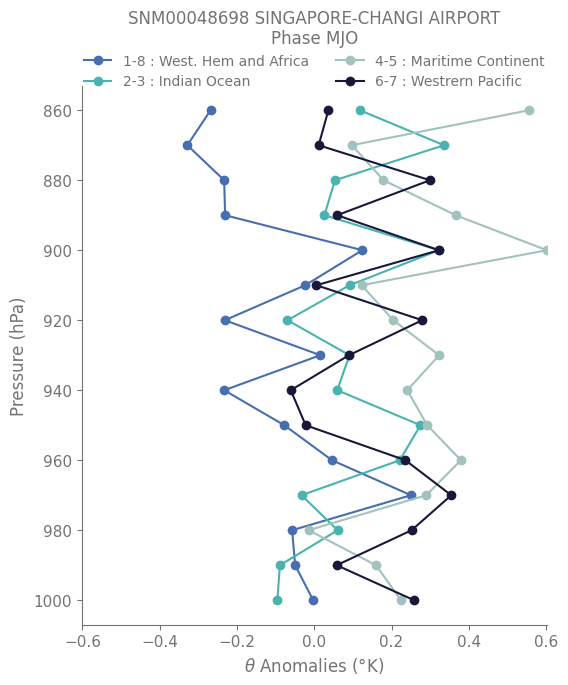

In [278]:
var = 'doy_theta_anom'
for lvl,composite in zip(['slv','llv'],[composite_data_slv, composite_data_llv]):
  for station in all_station_mjo_quality_final['station'].unique():
    print(station)
    data = composite[composite['station'] == station]
    fig = plt.figure(figsize=(6, 7), facecolor='w', edgecolor='w')
    ax = fig.add_subplot(111)
    ax.plot(data.query('mjo_group == "1-8"')[var],
            data.query('mjo_group == "1-8"')['pressure_hPa'],
            ls='-',marker='o',c = '#476EAE',label="1-8 : West. Hem and Africa")
    ax.plot(data.query('mjo_group == "2-3"')[var],
            data.query('mjo_group == "2-3"')['pressure_hPa'],
            ls='-',marker='o',c = '#48B3AF',label="2-3 : Indian Ocean")
    ax.plot(data.query('mjo_group == "4-5"')[var],
            data.query('mjo_group == "4-5"')['pressure_hPa'],
            ls='-',marker='o',c = '#A1C2BD',label="4-5 : Maritime Continent")
    ax.plot(data.query('mjo_group == "6-7"')[var],
            data.query('mjo_group == "6-7"')['pressure_hPa'],
            ls='-',marker='o',c = '#19183B',label="6-7 : Westrern Pacific")
    ax.set_xlim(-data[var].abs().max(),data[var].abs().max())
    ax.invert_yaxis()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color((0.45, 0.45, 0.45))
    ax.tick_params(axis='both', which='major', labelsize=11, colors=(0.45, 0.45, 0.45))
    ax.set_xlabel(r'$\theta$ Anomalies (°K)', fontsize=12, color=(0.45, 0.45, 0.45))
    ax.set_ylabel('Pressure (hPa)', fontsize=12, color=(0.45, 0.45, 0.45))
    leg = ax.legend(title='Phase MJO', title_fontsize=12,
                    bbox_to_anchor=(0.5, 1.05), loc='center',frameon=False,
                    handlelength=2, ncol=2)
    leg.get_title().set_color((0.45, 0.45, 0.45))
    for text in leg.get_texts():
        text.set_color((0.45, 0.45, 0.45))
        text.set_fontsize(10)
    title = station + ' ' +metadata_station.query(f'id == "{station}"')['name'].str.replace('/','-').values[0]
    ax.set_title(title, fontsize=12, color=(0.45, 0.45, 0.45),pad=45)
    plt.savefig(path_fig + f'{var}_{station}_{lvl}_profiles.png', dpi=300, bbox_inches="tight",transparent=False)

## ESTIMACIONES N$^{2}$

In [279]:
interp_data_N2 =(all_station_mjo_quality_final
                 .groupby(['station', 'time'],group_keys=True)
                 .apply(interp_levels,include_groups=False)
                 .reset_index())
valid_data_N2  = interp_data_N2.dropna()

In [280]:
valid_data_N2['theta_1000'] = valid_data_N2['T_1000'] * (p0 / p_bottom) ** kappa
valid_data_N2['theta_850'] = valid_data_N2['T_850'] * (p0 / p_top) ** kappa
valid_data_N2['theta_mean'] = 0.5 * (valid_data_N2['theta_1000'] + valid_data_N2['theta_850'])
valid_data_N2['T_mean'] = 0.5 * (valid_data_N2['T_1000'] + valid_data_N2['T_850'])
valid_data_N2['delta_z'] = (Rd * valid_data_N2['T_mean'] / g) * log(p_bottom / p_top)
valid_data_N2['N2'] = (g / valid_data_N2['theta_mean']) * (valid_data_N2['theta_850'] - valid_data_N2['theta_1000']) / valid_data_N2['delta_z']
valid_data_N2['date'] = valid_data_N2['time'].dt.date
valid_data_N2['year'] = valid_data_N2['time'].dt.year
valid_data_N2['doy'] = valid_data_N2['time'].dt.dayofyear
ref_data = valid_data_N2[(valid_data_N2['year'] >= ref_start) & (valid_data_N2['year'] <= ref_end)]
clim_base = ref_data.groupby(['station', 'doy'])['N2'].agg(['mean', 'std'])
clim_rolled = clim_base.reset_index().copy() #groupby(['station']).rolling(window=15, center=True, min_periods=5).mean().droplevel([0]).reset_index()
clim_rolled.columns = ['station','doy','N2_clim','N2_std_clim']
valid_data_N2 = valid_data_N2.merge(clim_rolled, on=['station', 'doy'], how='left')
valid_data_N2['doy_N2_anom'] = valid_data_N2['N2'] - valid_data_N2['N2_clim']
valid_data_N2['doy_N2_anom_std'] = valid_data_N2['doy_N2_anom'] / valid_data_N2['N2_std_clim']
valid_data_N2_final = valid_data_N2.set_index('date').join(rmm, how='left').dropna()
valid_data_N2_final['mjo_group'] = valid_data_N2_final['phase'].map({1:'1-8', 8:'1-8', 2:'2-3', 3:'2-3', 4:'4-5', 5:'4-5', 6:'6-7', 7:'6-7'})

/tmp/ipython-input-3221132953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_N2['theta_1000'] = valid_data_N2['T_1000'] * (p0 / p_bottom) ** kappa
/tmp/ipython-input-3221132953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_N2['theta_850'] = valid_data_N2['T_850'] * (p0 / p_top) ** kappa
/tmp/ipython-input-3221132953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

## DISTRIBUCIONES

In [281]:
colors_mjo = {
    '1-8': '#476EAE',  # West. Hem and Africa
    '2-3': '#48B3AF',  # Indian Ocean
    '4-5': '#A1C2BD',  # Maritime Continent
    '6-7': '#19183B'   # Western Pacific
}

PSM00091408
SNM00048698


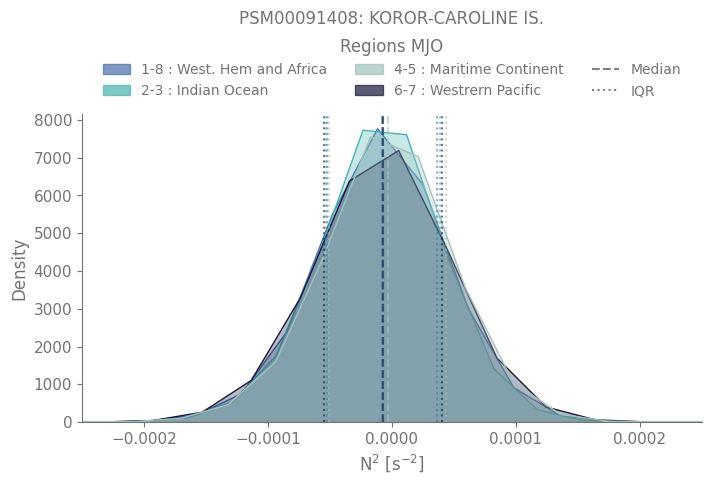

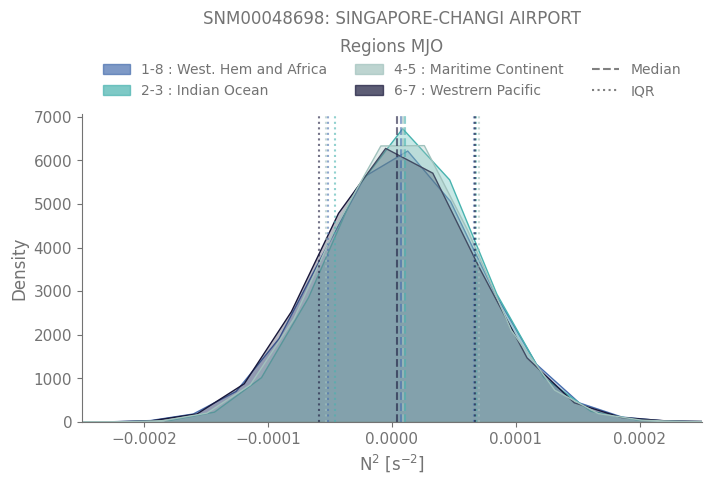

In [282]:
for station in valid_data_N2_final['station'].unique():
  print(station)
  data = valid_data_N2_final[valid_data_N2_final['station'] == station]
  summary_data = (data.groupby('mjo_group').agg({'doy_N2_anom':['mean','median','std',
                    ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25)),
                    ('LL', lambda x: x.median() - (x.quantile(0.75) - x.quantile(0.25))),
                    ('UL', lambda x: x.median() + (x.quantile(0.75) - x.quantile(0.25)))]}))
  fig = plt.figure(figsize=(8, 4), facecolor='w', edgecolor='w')
  ax = fig.add_subplot(111)
  kdeplot(data=data, x="doy_N2_anom", hue="mjo_group",
          fill=True, common_norm=False, alpha=0.3,
          palette=colors_mjo,ax=ax,legend=False)
  handles, labels_originales = ax.get_legend_handles_labels()
  ax.set_xlim(-0.00025,0.00025)
  for spine in ['top', 'right']:
      ax.spines[spine].set_visible(False)
  for spine in ['left', 'bottom']:
      ax.spines[spine].set_color((0.45, 0.45, 0.45))
  ax.tick_params(axis='both', which='major', labelsize=11, colors=(0.45, 0.45, 0.45))
  ax.set_xlabel(r'N$^{2}$ [s$^{-2}$]', fontsize=12, color=(0.45, 0.45, 0.45))
  ax.set_ylabel('Density', fontsize=12, color=(0.45, 0.45, 0.45))
  legend_elements = [
      Patch(color='#476EAE',alpha=.7, label='1-8 : West. Hem and Africa'),
      Patch(color='#48B3AF',alpha=.7, label='2-3 : Indian Ocean'),
      Patch(color='#A1C2BD',alpha=.7, label='4-5 : Maritime Continent'),
      Patch(color='#19183B',alpha=.7, label='6-7 : Westrern Pacific'),
      Line2D([0], [0], color='gray', linestyle='--', label='Median'),
      Line2D([0], [0], color='gray', linestyle=':', label='IQR')]

  leg = ax.legend(handles=legend_elements,
                  title='Regions MJO', title_fontsize=12,
                  bbox_to_anchor=(0.5, 1.15), loc='center',
                  frameon=False, fancybox=True, shadow=True,
                  handlelength=2, ncol=3)
  leg.get_title().set_color((0.45, 0.45, 0.45))
  for text in leg.get_texts():
      text.set_color((0.45, 0.45, 0.45))
      text.set_fontsize(10)

  [ax.axvline(x=summary_data.loc[group, ('doy_N2_anom', 'median')], color=colors_mjo[group], alpha=0.6, linestyle='--') for group in summary_data.index]
  [ax.axvline(x=summary_data.loc[group, ('doy_N2_anom', 'UL')], color=colors_mjo[group], alpha=0.6, linestyle=':') for group in summary_data.index]
  [ax.axvline(x=summary_data.loc[group, ('doy_N2_anom', 'LL')], color=colors_mjo[group], alpha=0.6, linestyle=':') for group in summary_data.index]
  title = station + ': ' +metadata_station.query(f'id == "{station}"')['name'].str.replace('/','-').values[0]
  ax.set_title(title, fontsize=12, color=(0.45, 0.45, 0.45),pad=65)
  plt.savefig(path_fig + f'N2anom_{station}.png', dpi=300, bbox_inches="tight",transparent=False)
